In [1]:
# coding: UTF-8

import os
import time
from datetime import datetime
import numpy as np
import pandas as pd
import random
import sys
import glob
from scipy import stats

import tensorflow as tf
from proposal_GANs import MY_GAN

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

import xlsxwriter

from tensorflow.python.client import timeline

class pycolor:
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    PURPLE = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'
    END = '\033[0m'
    BOLD = '\038[1m'
    UNDERLINE = '\033[4m'
    INVISIBLE = '\033[08m'
    REVERCE = '\033[07m'

In [2]:
FLAGS = tf.app.flags.FLAGS

tf.app.flags.DEFINE_string('logdir', 'param/artifical_fit/',
                           """Directory where to write event logs and checkpoint.""")
tf.app.flags.DEFINE_string('results_dir', 'data/gan_output/cleared_',
                           """Directory where to write generated signals.""")
tf.app.flags.DEFINE_string('data_dir', '../data',
                           """Path to the raw data directory.""")
tf.app.flags.DEFINE_integer('num_examples_per_epoch_for_train', 5000,
                            """number of examples for train""")
tf.app.flags.DEFINE_integer('max_steps', 10,
                            """Number of steps to run.""")
tf.app.flags.DEFINE_integer('batch_size', 64,
                            """Size of batch in each steps""")

BATCH_LENGTH = 5000

np.random.seed(7)

loading eeg data ...


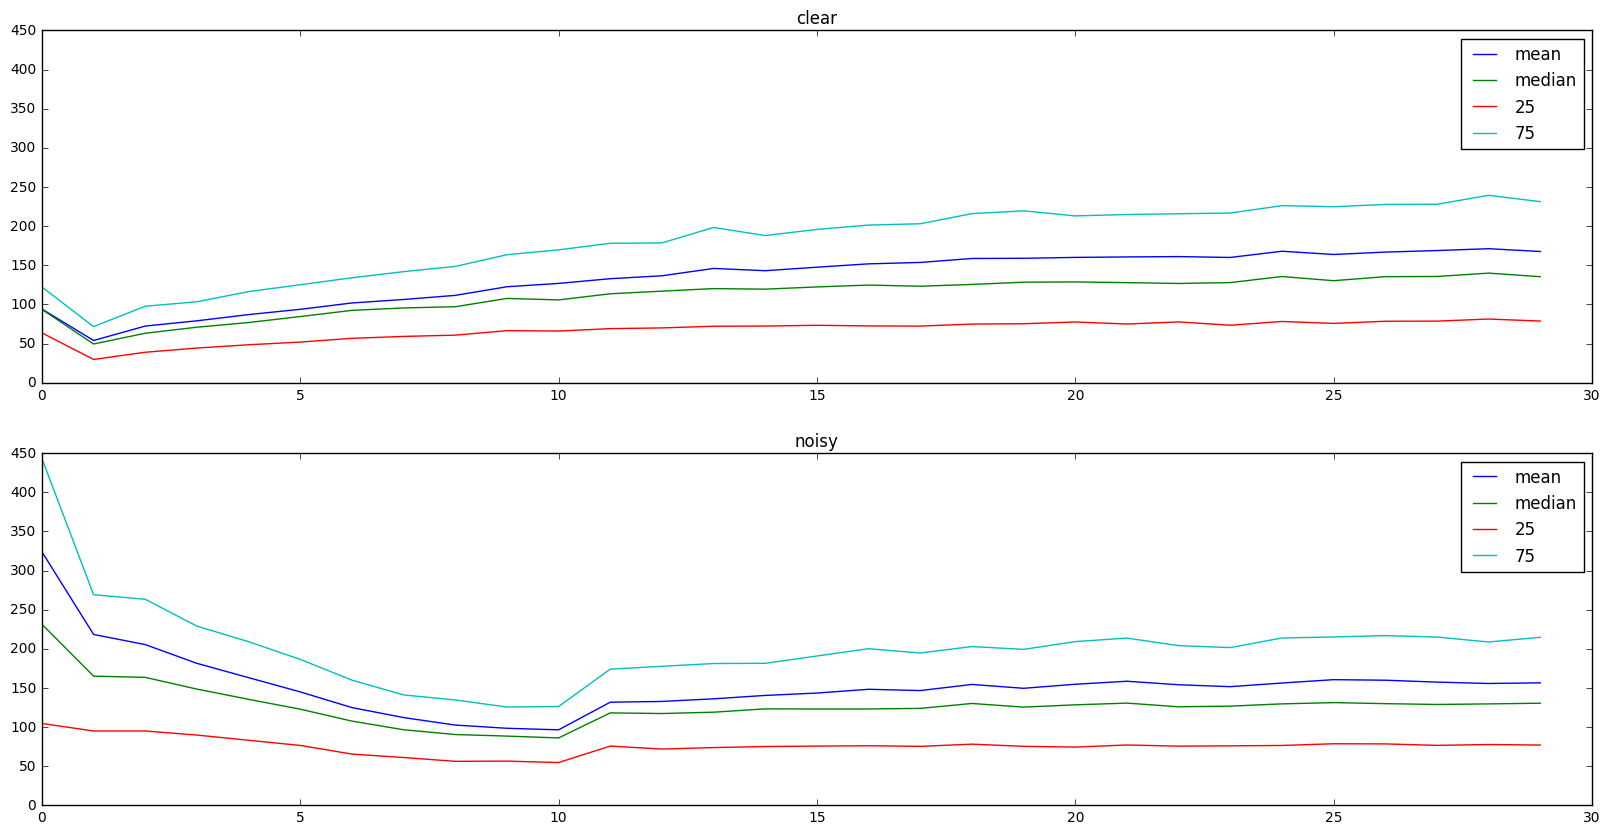

(64, 1, 5000, 128)
(64, 1, 5000, 512)
(64, 1, 5000, 128)
(64, 1, 5000, 512)
(64, 1, 5000, 128)
(64, 1, 5000, 512)
(64, 1, 5000, 128)
(64, 1, 5000, 512)
(64, 1, 5000, 128)
(64, 1, 5000, 512)


In [3]:
%matplotlib inline

TrainData_list = []
InputData_list = []
Data_list = []

#load the eeg data
print('loading eeg data ...')

train_eeg = pd.read_csv('./data/clear/eeg_B6J10.csv', header=None, index_col=None)
train_eeg = train_eeg.as_matrix().reshape(-1, BATCH_LENGTH)
train_eeg = train_eeg[0:2000]

noisy_eeg = pd.read_csv('./data/noisy/low_noisy_eeg_B6J5.csv', header=None, index_col=None).as_matrix()
noisy_eeg = noisy_eeg.reshape(-1,BATCH_LENGTH)
noisy_eeg = noisy_eeg[0:2000]

clear_F = np.fft.fft(train_eeg)
clear_F_amp = abs(clear_F)
clear_F_angle= np.angle(clear_F)
noisy_F = np.fft.fft(noisy_eeg)
noisy_F_amp = abs(noisy_F)
noisy_F_angle= np.angle(noisy_F)

ylim = [0,450]

pre_fig = plt.figure(figsize=(20,10))
pre_ax1 = pre_fig.add_subplot(211)
pre_ax1.plot(np.mean(clear_F_amp/2500, axis=0)[0:30], label='mean')
pre_ax1.plot(np.median(clear_F_amp/2500, axis=0)[0:30], label='median')
pre_ax1.plot(stats.scoreatpercentile(clear_F_amp/2500, 25, axis=0)[0:30], label='25')
pre_ax1.plot(stats.scoreatpercentile(clear_F_amp/2500, 75, axis=0)[0:30], label='75')
plt.ylim(ylim)
plt.title('clear')
plt.legend()

pre_ax2 = pre_fig.add_subplot(212)
pre_ax2.plot(np.mean(noisy_F_amp/2500, axis=0)[0:30], label='mean')
pre_ax2.plot(np.median(noisy_F_amp/2500, axis=0)[0:30], label='median')
pre_ax2.plot(stats.scoreatpercentile(noisy_F_amp/2500, 25, axis=0)[0:30], label='25')
pre_ax2.plot(stats.scoreatpercentile(noisy_F_amp/2500, 75, axis=0)[0:30], label='75')
plt.ylim(ylim)
plt.title('noisy')
plt.legend()

plt.show()

mygan = MY_GAN(s_size=4, batch_size=FLAGS.batch_size)

noisydata_train_ph = tf.placeholder(tf.float32, shape = [FLAGS.batch_size, 1, BATCH_LENGTH, 1], name='noisydata_train')
traindata_train_ph = tf.placeholder(tf.float32, shape = [FLAGS.batch_size, 1, BATCH_LENGTH, 1], name='traindata_train')
noisydata_ph = tf.placeholder(tf.float32, shape = [FLAGS.batch_size, 1, BATCH_LENGTH, 1], name='noisydata')

losses = mygan.loss(noisydata_train_ph, traindata_train_ph)
g_loss_pretraining_op = mygan.loss_G_pretraining(noisydata_train_ph, traindata_train_ph)
d_loss_pretraining_op = mygan.loss_D_pretraining(noisydata_train_ph, traindata_train_ph)
g_losses = mygan.loss_G_only(noisydata_train_ph, traindata_train_ph)
d_losses = mygan.loss_D_only(noisydata_train_ph, traindata_train_ph)
train_op = mygan.train(losses, g_learning_rate=0.01, d_learning_rate=0.0001)
G_pretraining_op = mygan.G_pretraining(g_loss_pretraining_op, g_learning_rate=0.0001)
D_pretraining_op = mygan.D_pretraining(d_loss_pretraining_op, d_learning_rate=0.0001)
g_train_only_op = mygan.G_only_training(g_losses, g_learning_rate=0.0001)
d_train_only_op = mygan.D_only_training(d_losses, d_learning_rate=0.0001)

signals = mygan.sample_signals(inputs = noisydata_ph)

clear_ph = tf.placeholder(tf.float32, name='clear')
sin_ph = tf.placeholder(tf.float32, name='sin')

#feature matching
graph = tf.get_default_graph()

g_saver = tf.train.Saver(dcgan.g.variables, max_to_keep=15)
d_saver = tf.train.Saver(dcgan.d.variables, max_to_keep=15)
g_checkpoint_path = os.path.join(FLAGS.logdir, 'g/g_fit_4000.ckpt')
d_checkpoint_path = os.path.join(FLAGS.logdir, 'd/d_fit_4000.ckpt')

g_loss_list = []
g_loss_fit_list = []
g_loss_rec_list = []
g_loss_noise_list = []
d_loss_list = []
g_predict_list = []
t_predict_list = []

gpuConfig = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
        per_process_gpu_memory_fraction=1.0,
        visible_device_list=''),
    #device_count={'GPU': 4}
 )

In [ ]:
with tf.Session(config=gpuConfig) as sess:
    #summary_writer = tf.summary.FileWriter(FLAGS.logdir, graph=sess.graph)
    # restore or initialize generator
    sess.run(tf.global_variables_initializer())

    #g_saver.restore(sess, FLAGS.logdir + 'g/g.ckpt-30')
    #g_saver.restore(sess, FLAGS.logdir + 'g_pre/g_pretrained.ckpt-15')
    #d_saver.restore(sess, FLAGS.logdir + 'd/d.ckpt-31')

    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
    run_metadata = tf.RunMetadata()

    # setup for monitoring

    #signals = dcgan.sample_signals(inputs = noisydata_ph)

    with tf.name_scope('summary'):
        writer = tf.summary.FileWriter('./tensorboard/tensorboard-log', sess.graph)
        d_loss_summary = tf.summary.scalar('d_loss', d_losses['d_l'])
        g_pre_summary = tf.summary.scalar('g_predict', d_losses['g_pre'][1])
        t_pre_summary = tf.summary.scalar('t_predict', d_losses['t_pre'][1])
        g_loss_summary = tf.summary.scalar('g_loss', g_losses['g_l'])
        g_loss_fit_summary = tf.summary.scalar('g_loss_fit', g_losses['g_lf'])
        g_loss_rec_summary = tf.summary.scalar('g_loss_rec', g_losses['g_lr'])
        g_loss_noise_summary = tf.summary.scalar('g_loss_noise', g_losses['g_ln'])
        g_pre_loss_summary = tf.summary.scalar('g_pre_loss', g_loss_pretraining_op[0])

    print 'start training...'
    #Wlole system training
    for step in range(FLAGS.max_steps):
        g_predict_list = []
        t_predict_list = []

        start_time = time.time()

        ERROR = tf.constant(0)

        #Discriminator training
        for batch_step in range(len(train_eeg) / FLAGS.batch_size):
            batch_noisy_eeg = noisy_F_amp[batch_step * FLAGS.batch_size : (batch_step + 1) * FLAGS.batch_size, :]
            batch_train_eeg = clear_F_amp[batch_step * FLAGS.batch_size : (batch_step + 1) * FLAGS.batch_size, :]

            batch_noisy_eeg = np.reshape(batch_noisy_eeg, (-1, 1, BATCH_LENGTH, 1))
            batch_train_eeg = np.reshape(batch_train_eeg, (-1, 1, BATCH_LENGTH, 1))
            batch_train_dict = {noisydata_train_ph: batch_noisy_eeg, traindata_train_ph: batch_train_eeg}
            D_train_list = [d_train_only_op, d_losses['d_l'], d_losses['g_pre'], d_losses['t_pre'], d_loss_summary, g_pre_summary, t_pre_summary, d_losses['err']]

            if(batch_noisy_eeg.shape == (FLAGS.batch_size, 1, BATCH_LENGTH, 1) and batch_train_eeg.shape == (FLAGS.batch_size, 1, BATCH_LENGTH, 1)):
                _, d_loss, g_predict, t_predict, dl_summary, gp_summary, tp_summary, err = sess.run(
                    D_train_list, feed_dict=batch_train_dict)

            ERROR = tf.add(ERROR, err)

        #print('error rate : {}'.format(sess.run(AMT)))

        d_loss_list.append(d_loss)
        g_predict_list.append(g_predict[1])
        t_predict_list.append(t_predict[1])

        #Generator training
        for i in range(G_PER_D):

            for batch_step in range(len(train_eeg) / FLAGS.batch_size):
                batch_noisy_eeg = noisy_F_amp[batch_step * FLAGS.batch_size : (batch_step + 1) * FLAGS.batch_size, :]
                batch_train_eeg = clear_F_amp[batch_step * FLAGS.batch_size : (batch_step + 1) * FLAGS.batch_size, :]

                batch_noisy_eeg = np.reshape(batch_noisy_eeg, (-1, 1, BATCH_LENGTH, 1))
                batch_train_eeg = np.reshape(batch_train_eeg, (-1, 1, BATCH_LENGTH, 1))
                batch_train_dict = {noisydata_train_ph: batch_noisy_eeg, traindata_train_ph: batch_train_eeg}
                G_train_list = [g_train_only_op, g_losses['g_l'], g_losses['g_lf'], g_losses['g_lr'], g_losses['g_ln'], g_loss_summary, g_loss_fit_summary, g_loss_rec_summary, g_loss_noise_summary]

                if(batch_noisy_eeg.shape == (FLAGS.batch_size, 1, BATCH_LENGTH, 1) and batch_train_eeg.shape == (FLAGS.batch_size, 1, BATCH_LENGTH, 1)):
                    _, g_loss, g_loss_fit, g_loss_rec, g_loss_noise, gl_summary, glf_summary, glr_summary, gln_summary = sess.run(
                        G_train_list, feed_dict=batch_train_dict,
                        options=run_options, run_metadata=run_metadata)
            print(('g_loss -> ' + pycolor.RED + 'All' + pycolor.END + ': {:e}, ' + pycolor.GREEN + 'Fit' + pycolor.END + ': {:e}, ' + pycolor.YELLOW + 'Rec' + pycolor.END + ': {:e}, ' + pycolor.BLUE + 'Noise' + pycolor.END + ': {:e}').format(g_loss, g_loss_fit, g_loss_rec, g_loss_noise))

            g_loss_list.append(g_loss)
            g_loss_fit_list.append(g_loss_fit)
            g_loss_rec_list.append(g_loss_rec)
            g_loss_noise_list.append(g_loss_noise)

        t_predict_mean = sum(t_predict_list)/len(t_predict_list)
        g_predict_mean = sum(g_predict_list)/len(g_predict_list)

        duration = time.time() - start_time
        print('{}: step {:5d}, loss = (Generator: {:e}, Discriminator: {:e}), ({:.3f} sec/batch)'.format(
            datetime.now(), step, g_loss, d_loss, duration))
        print('')
        print('g_loss_fit: {:e}, g_loss_rec: {:e}, g_loss_noise: {:e}'.format(
            g_loss_fit, g_loss_rec, g_loss_noise))
        print('')
        print('Generated is Training: {:e}, Training is Training: {:e}'.format(
            g_predict_mean, t_predict_mean))

    print('training finished !')
    

In [4]:
with tf.Session(config=gpuConfig) as sess:
    g_saver.restore(sess, FLAGS.logdir + 'g/g_fit_4000.ckpt-10')
    print('prediction noisydata start ...')

    test_noisy_eeg = np.empty((0, BATCH_LENGTH))
    cleared_F_amp = np.empty((0, BATCH_LENGTH))
    noise_F_amp = np.empty((0, BATCH_LENGTH))

    test_noisy_eeg = np.append(test_noisy_eeg, pd.read_csv('./data/noisy/low_noisy_eeg_B6J5.csv', header=None, index_col=None).as_matrix())

    test_noisy_eeg = test_noisy_eeg.reshape(-1, BATCH_LENGTH)[2000:4000]
    test_noisy_F = np.fft.fft(test_noisy_eeg)
    test_noisy_F_amp = abs(test_noisy_F)
    test_noisy_F_angle = np.angle(test_noisy_F)

    for batch_step in range(len(test_noisy_F_amp) / FLAGS.batch_size):
        batch_noisy_eeg = test_noisy_F_amp[batch_step * FLAGS.batch_size : (batch_step + 1) * FLAGS.batch_size, :]
        batch_noisy_eeg = np.reshape(batch_noisy_eeg, (-1, 1, BATCH_LENGTH, 1))

        if(batch_noisy_eeg.shape == (FLAGS.batch_size, 1, BATCH_LENGTH, 1)):
            batch_cleared, batch_noise = sess.run(signals, feed_dict={noisydata_ph: batch_noisy_eeg})
            batch_cleared = batch_cleared.reshape(-1, BATCH_LENGTH)
            cleared_F_amp = np.append(cleared_F_amp, batch_cleared, axis=0)
            batch_noise = batch_noise.reshape(-1, BATCH_LENGTH)
            noise_F_amp = np.append(noise_F_amp, batch_noise, axis=0)

    Im_tmp = np.array([[1j for j in range(cleared_F_amp.shape[-1])] for i in range(len(cleared_F_amp))])
    print ('cleared_F_amp.shape : {}'.format(cleared_F_amp.shape))
    print ('test_noisy_F_angle.shape : {}'.format(test_noisy_F_angle.shape))
    print ('Im_tmp.shape : {}'.format(Im_tmp.shape))
    cleared_F = cleared_F_amp * np.cos(test_noisy_F_angle[:len(cleared_F_amp)]) + cleared_F_amp * np.sin(test_noisy_F_angle[:len(cleared_F_amp)]) * Im_tmp
    cleared_eeg = np.fft.ifft(cleared_F)
    cleared_eeg = cleared_eeg.ravel()
    
    noise_F = noise_F_amp * np.cos(test_noisy_F_angle[:len(noise_F_amp)]) + noise_F_amp * np.sin(test_noisy_F_angle[:len(noise_F_amp)]) * Im_tmp
    noise_eeg = np.fft.ifft(noise_F)
    noise_eeg = noise_eeg.ravel()

    print('prediction noisydata finished !')

    print('')

INFO:tensorflow:Restoring parameters from param/artifical_fit/g/g_fit_4000.ckpt-10
prediction noisydata start ...
cleared_F_amp.shape : (1984, 5000)
test_noisy_F_angle.shape : (2000, 5000)
Im_tmp.shape : (1984, 5000)
prediction noisydata finished !



In [26]:
#compare "the spectrum of noisydata before added noise" and "cleared spectrum"
original_eeg = pd.read_csv('./data/clear/eeg_B6J5.csv', header=None, index_col=None).as_matrix()
original_eeg = original_eeg.reshape(-1,BATCH_LENGTH)[2000:4000]

original_F = np.fft.fft(original_eeg)
original_F_amp = abs(original_F)
original_F_angle = np.angle(original_F)

print(original_F_amp[0:len(cleared_F_amp),0:len(cleared_F_amp[0])/2].shape)
#print(len(cleared_F_amp))

sihyou1 = np.mean(np.mean((original_F_amp[0:len(cleared_F_amp),0:len(cleared_F_amp[0])/2]/2500 - cleared_F_amp[:, 0:len(cleared_F_amp[0])/2]/2500) ** 2, axis=0), axis=0)
sihyou2_low = np.mean(np.mean((cleared_F_amp[:, 0:11]/2500 - test_noisy_F_amp[0:len(cleared_F_amp), 0:11]/2500) ** 2, axis=0), axis=0)
sihyou2_high = np.mean(np.mean((cleared_F_amp[:, 11:2500]/2500 - test_noisy_F_amp[0:len(cleared_F_amp), 11:2500]/2500) ** 2, axis=0), axis=0)

print('siyou1 : {}'.format(sihyou1))
print('siyou2_low : {}'.format(sihyou2_low))
print('siyou2_high : {}'.format(sihyou2_high))

(1984, 2500)
siyou1 : 155.742425794
siyou2_low : 3553.17993146
siyou2_high : 1.37481992529


5000


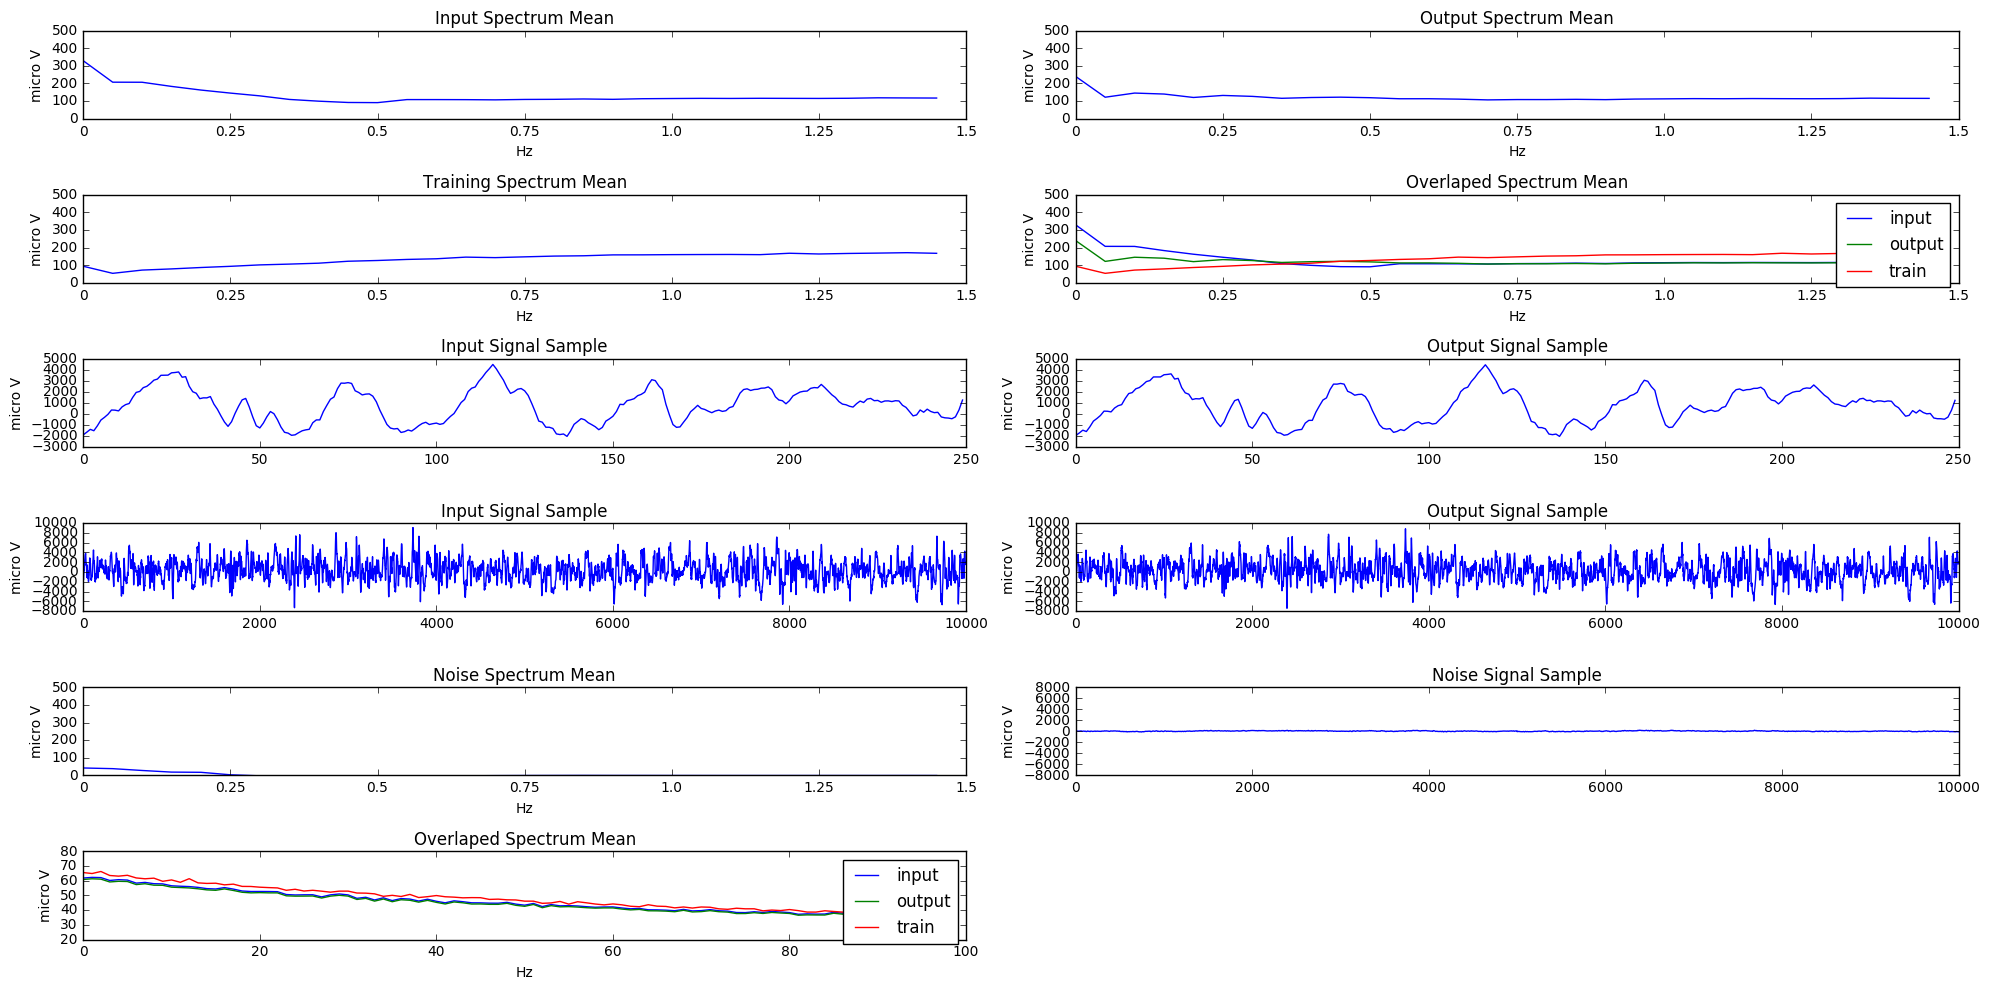

In [21]:
%matplotlib inline

fig = plt.figure(figsize=(20,10))

y_lim = [0,500]

ax1 = fig.add_subplot(621)
ax1.plot(np.mean(test_noisy_F_amp/2500, axis=0)[0:30])
plt.xticks([0,5,10,15,20,25,30], ['0','0.25','0.5','0.75','1.0','1.25','1.5'])
plt.title('Input Spectrum Mean')
plt.xlabel('Hz')
plt.ylabel('micro V')
ax1.set_ylim(y_lim)

ax2 = fig.add_subplot(622)
ax2.plot(np.mean(cleared_F_amp/2500, axis=0)[0:30])
#ax2.plot(np.median(cleared_F_amp/2500, axis=0)[0:30], label='median')
#ax2.plot(stats.scoreatpercentile(cleared_F_amp/2500, 25, axis=0)[0:30], label='25')
#ax2.plot(stats.scoreatpercentile(cleared_F_amp/2500, 75, axis=0)[0:30], label='75')
plt.xticks([0,5,10,15,20,25,30], ['0','0.25','0.5','0.75','1.0','1.25','1.5'])
plt.title('Output Spectrum Mean')
plt.xlabel('Hz')
plt.ylabel('micro V')
ax2.set_ylim(y_lim)

ax5 = fig.add_subplot(623)
ax5.plot(np.mean(clear_F_amp/2500, axis=0)[0:30])
plt.xticks([0,5,10,15,20,25,30], ['0','0.25','0.5','0.75','1.0','1.25','1.5'])
plt.title('Training Spectrum Mean')
plt.xlabel('Hz')
plt.ylabel('micro V')
ax5.set_ylim(y_lim)

ax6 = fig.add_subplot(624)
ax6.plot(np.mean(test_noisy_F_amp/2500, axis=0)[0:30], label="input")
ax6.plot(np.mean(cleared_F_amp/2500, axis=0)[0:30], label="output")
ax6.plot(np.mean(clear_F_amp/2500, axis=0)[0:30], label="train")
plt.xticks([0,5,10,15,20,25,30], ['0','0.25','0.5','0.75','1.0','1.25','1.5'])
plt.title('Overlaped Spectrum Mean')
plt.xlabel('Hz')
plt.ylabel('micro V')
ax6.set_ylim(y_lim)
plt.legend()

ax3 = fig.add_subplot(625)
ax3.plot(test_noisy_eeg.ravel()[0:250])
plt.title('Input Signal Sample')
plt.ylabel('micro V')

ax4 = fig.add_subplot(626)
ax4.plot(cleared_eeg[0:250])
plt.title('Output Signal Sample')
plt.ylabel('micro V')

ax7 = fig.add_subplot(627)
ax7.plot(test_noisy_eeg.ravel()[0:10000])
plt.title('Input Signal Sample')
plt.ylabel('micro V')

ax8 = fig.add_subplot(628)
ax8.plot(cleared_eeg[0:10000])
plt.title('Output Signal Sample')
plt.ylabel('micro V')

ax9 = fig.add_subplot(629)
ax9.plot(np.mean(noise_F_amp/2500, axis=0)[0:30])
plt.xticks([0,5,10,15,20,25,30], ['0','0.25','0.5','0.75','1.0','1.25','1.5'])
plt.title('Noise Spectrum Mean')
plt.xlabel('Hz')
plt.ylabel('micro V')
ax9.set_ylim(y_lim)

ax10 = fig.add_subplot(6,2,10)
ax10.plot(noise_eeg[0:10000])
plt.title('Noise Signal Sample')
plt.ylabel('micro V')
ax10.set_ylim(-8000,8000)

ax11 = fig.add_subplot(6,2,11)
ax11.plot(np.mean(test_noisy_F_amp[:, 200:300]/2500, axis=0), label="input")
ax11.plot(np.mean(cleared_F_amp[:, 200:300]/2500, axis=0), label="output")
ax11.plot(np.mean(clear_F_amp[:, 200:300]/2500, axis=0), label="train")
plt.title('Overlaped Spectrum Mean')
plt.xlabel('Hz')
plt.ylabel('micro V')
ax11.set_ylim(20,80)
plt.legend()

plt.tight_layout()

print(len(cleared_F_amp[0]))